In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.layers import Input, Dense, Dropout, Activation
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json

In [253]:
rating = pd.read_csv('dataframeSVD.csv')
# ratings = pd.DataFrame(zip(rating.user_id, rating.item_id, rating.sentiment_score), columns = ['user_id', 'item_id', 'sentiment_score'])
# ratings.head()

In [143]:
# users = ratings['user_id'].unique()
# for index, row in ratings.iterrows():
#     for i in range(7817):
#         if row['user_id'] == users[i]:
#             ratings.loc[index, 'user_id'] = i
#             break;
#     print(index)

In [144]:
# items = ratings['item_id'].unique()
# for index, row in ratings.iterrows():
#     for i in range(2167):
#         if row['item_id'] == items[i]:
#             ratings.loc[index, 'item_id'] = i
#             break;
#     print(index)

In [145]:
# ratings.to_csv('ratings_clean.csv', index = False)

In [254]:
items = ratings['Item ID'].unique()
users = ratings['User ID'].unique()

In [255]:
ratings = pd.read_csv('dataframeAutoEncoder.csv')

In [256]:
num_items = len(ratings['Item ID'].unique())
num_users = len(ratings['User ID'].unique())

In [257]:
# num_items = len(ratings['item_id'].unique())
# num_users = len(ratings['user_id'].unique())

In [258]:
train_df, test_df = train_test_split(ratings,
                                     test_size=0.1)

In [259]:
train_df.head(5)

,User ID,Item ID,SentimentScore
29671,5150,258,3
35033,6293,495,3
10048,8265,10,3
23420,14555,117,3
15164,11132,30,3


In [260]:
train_df, validate_df = train_test_split(train_df,
                                     test_size=0.1,)

In [261]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [262]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_items, 0)
users_items_matrix_validate = dataPreprocessor(validate_df, num_users, num_items, 0)
users_items_matrix_test = dataPreprocessor(test_df, num_users, num_items, 0)

In [263]:
users_items_matrix_train_average = dataPreprocessor(train_df, num_users, num_items, average=True)

In [264]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [265]:
def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [266]:
def masked_mse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse

In [267]:
def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [268]:

def masked_rmse_clip(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 5)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [269]:
def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output
    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model


In [270]:
layers = [512, 256, 128, 256, 512]
dropout = 0.2
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [271]:
tf.compat.v1.disable_eager_execution()

In [272]:
# Build model
Deep_AE = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse, masked_rmse_clip]) 
Deep_AE.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      [(None, 2789)]            0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 512)               1428480   
_________________________________________________________________
EncLayer1 (Dense)            (None, 256)               131328    
_________________________________________________________________
LatentSpace (Dense)          (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 256)               33024     
_________________________________________________________________
DecLayer0 (Dense)            (None, 512)               1315

In [273]:
hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=200,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=1)

Train on 19873 samples, validate on 19873 samples
Epoch 1/200
19873/19873 [==============================] - 13s 639us/sample - loss: 8.2283 - masked_rmse: 2.0544 - masked_rmse_clip: 1.6449 - val_loss: 3.8034 - val_masked_rmse: 0.4684 - val_masked_rmse_clip: 0.3739
Epoch 2/200
19873/19873 [==============================] - 11s 545us/sample - loss: 4.2065 - masked_rmse: 1.0103 - masked_rmse_clip: 0.9241 - val_loss: 2.8900 - val_masked_rmse: 0.2657 - val_masked_rmse_clip: 0.2516
Epoch 3/200
19873/19873 [==============================] - 10s 523us/sample - loss: 2.9790 - masked_rmse: 0.5843 - masked_rmse_clip: 0.5660 - val_loss: 2.6621 - val_masked_rmse: 0.2208 - val_masked_rmse_clip: 0.2137
Epoch 4/200
19873/19873 [==============================] - 13s 657us/sample - loss: 2.6265 - masked_rmse: 0.4644 - masked_rmse_clip: 0.4610 - val_loss: 2.5698 - val_masked_rmse: 0.2148 - val_masked_rmse_clip: 0.2066
Epoch 5/200
19873/19873 [==============================] - 11s 562us/sample - loss: 2.

19873/19873 [==============================] - 12s 609us/sample - loss: 0.8251 - masked_rmse: 0.2581 - masked_rmse_clip: 0.2563 - val_loss: 1.4337 - val_masked_rmse: 0.2854 - val_masked_rmse_clip: 0.2425
Epoch 39/200
19873/19873 [==============================] - 14s 682us/sample - loss: 0.8040 - masked_rmse: 0.2588 - masked_rmse_clip: 0.2567 - val_loss: 1.3983 - val_masked_rmse: 0.2825 - val_masked_rmse_clip: 0.2410
Epoch 40/200
19873/19873 [==============================] - 12s 594us/sample - loss: 0.7824 - masked_rmse: 0.2575 - masked_rmse_clip: 0.2554 - val_loss: 1.3677 - val_masked_rmse: 0.2797 - val_masked_rmse_clip: 0.2386
Epoch 41/200
19873/19873 [==============================] - 14s 681us/sample - loss: 0.7601 - masked_rmse: 0.2558 - masked_rmse_clip: 0.2537 - val_loss: 1.3237 - val_masked_rmse: 0.2738 - val_masked_rmse_clip: 0.2349
Epoch 42/200
19873/19873 [==============================] - 14s 703us/sample - loss: 0.7427 - masked_rmse: 0.2581 - masked_rmse_clip: 0.2561 - va

Epoch 76/200
19873/19873 [==============================] - 11s 542us/sample - loss: 0.3727 - masked_rmse: 0.2361 - masked_rmse_clip: 0.2346 - val_loss: 0.8527 - val_masked_rmse: 0.2500 - val_masked_rmse_clip: 0.2222
Epoch 77/200
19873/19873 [==============================] - 11s 572us/sample - loss: 0.3680 - masked_rmse: 0.2354 - masked_rmse_clip: 0.2338 - val_loss: 0.8415 - val_masked_rmse: 0.2490 - val_masked_rmse_clip: 0.2224
Epoch 78/200
19873/19873 [==============================] - 11s 572us/sample - loss: 0.3623 - masked_rmse: 0.2344 - masked_rmse_clip: 0.2330 - val_loss: 0.8236 - val_masked_rmse: 0.2445 - val_masked_rmse_clip: 0.2189
Epoch 79/200
19873/19873 [==============================] - 13s 678us/sample - loss: 0.3570 - masked_rmse: 0.2327 - masked_rmse_clip: 0.2312 - val_loss: 0.8306 - val_masked_rmse: 0.2470 - val_masked_rmse_clip: 0.2203
Epoch 80/200
19873/19873 [==============================] - 13s 657us/sample - loss: 0.3523 - masked_rmse: 0.2313 - masked_rmse_clip

19873/19873 [==============================] - 11s 548us/sample - loss: 0.2728 - masked_rmse: 0.2211 - masked_rmse_clip: 0.2197 - val_loss: 0.7321 - val_masked_rmse: 0.2411 - val_masked_rmse_clip: 0.2175
Epoch 114/200
19873/19873 [==============================] - 11s 551us/sample - loss: 0.2718 - masked_rmse: 0.2221 - masked_rmse_clip: 0.2209 - val_loss: 0.7330 - val_masked_rmse: 0.2423 - val_masked_rmse_clip: 0.2193
Epoch 115/200
19873/19873 [==============================] - 12s 622us/sample - loss: 0.2693 - masked_rmse: 0.2203 - masked_rmse_clip: 0.2188 - val_loss: 0.7307 - val_masked_rmse: 0.2406 - val_masked_rmse_clip: 0.2166
Epoch 116/200
19873/19873 [==============================] - 11s 549us/sample - loss: 0.2668 - masked_rmse: 0.2180 - masked_rmse_clip: 0.2165 - val_loss: 0.7306 - val_masked_rmse: 0.2415 - val_masked_rmse_clip: 0.2176
Epoch 117/200
19873/19873 [==============================] - 12s 600us/sample - loss: 0.2676 - masked_rmse: 0.2208 - masked_rmse_clip: 0.2195 

19873/19873 [==============================] - 12s 625us/sample - loss: 0.2377 - masked_rmse: 0.2115 - masked_rmse_clip: 0.2099 - val_loss: 0.7006 - val_masked_rmse: 0.2398 - val_masked_rmse_clip: 0.2171
Epoch 151/200
19873/19873 [==============================] - 12s 583us/sample - loss: 0.2357 - masked_rmse: 0.2074 - masked_rmse_clip: 0.2060 - val_loss: 0.6858 - val_masked_rmse: 0.2366 - val_masked_rmse_clip: 0.2159
Epoch 152/200
19873/19873 [==============================] - 11s 549us/sample - loss: 0.2367 - masked_rmse: 0.2110 - masked_rmse_clip: 0.2095 - val_loss: 0.7009 - val_masked_rmse: 0.2398 - val_masked_rmse_clip: 0.2168
Epoch 153/200
19873/19873 [==============================] - 10s 512us/sample - loss: 0.2367 - masked_rmse: 0.2116 - masked_rmse_clip: 0.2101 - val_loss: 0.7047 - val_masked_rmse: 0.2417 - val_masked_rmse_clip: 0.2187
Epoch 154/200
19873/19873 [==============================] - 10s 519us/sample - loss: 0.2356 - masked_rmse: 0.2112 - masked_rmse_clip: 0.2098 

Epoch 188/200
19873/19873 [==============================] - 5s 232us/sample - loss: 0.2207 - masked_rmse: 0.2046 - masked_rmse_clip: 0.2032 - val_loss: 0.6865 - val_masked_rmse: 0.2395 - val_masked_rmse_clip: 0.2170
Epoch 189/200
19873/19873 [==============================] - 5s 237us/sample - loss: 0.2188 - masked_rmse: 0.2019 - masked_rmse_clip: 0.2005 - val_loss: 0.6884 - val_masked_rmse: 0.2389 - val_masked_rmse_clip: 0.2155
Epoch 190/200
19873/19873 [==============================] - 4s 210us/sample - loss: 0.2161 - masked_rmse: 0.1986 - masked_rmse_clip: 0.1969 - val_loss: 0.6786 - val_masked_rmse: 0.2375 - val_masked_rmse_clip: 0.2157
Epoch 191/200
19873/19873 [==============================] - 5s 252us/sample - loss: 0.2166 - masked_rmse: 0.1991 - masked_rmse_clip: 0.1978 - val_loss: 0.6771 - val_masked_rmse: 0.2373 - val_masked_rmse_clip: 0.2159
Epoch 192/200
19873/19873 [==============================] - 5s 241us/sample - loss: 0.2183 - masked_rmse: 0.2024 - masked_rmse_clip

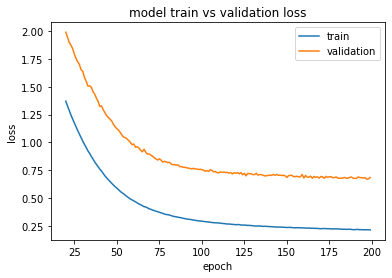

In [285]:
show_error(hist_Deep_AE, 20)

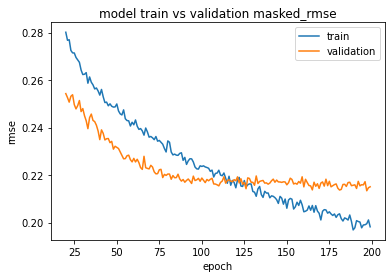

In [286]:
show_rmse(hist_Deep_AE, 20)

In [276]:
predict_deep = Deep_AE.predict(users_items_matrix_train_zero)

In [277]:
test_result_deep = Deep_AE.evaluate(users_items_matrix_train_zero, users_items_matrix_test)

19873/19873 [==============================] - 3s 137us/sample - loss: 0.7627 - masked_rmse: 0.2727 - masked_rmse_clip: 0.2455


In [278]:
def save_model(name, model):
  # # serialize model to JSON
  model_json = model.to_json()
  with open("{}.json".format(name), "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("{}.h5".format(name))
  print("Saved model to disk")

In [279]:
def load_model(name):
  # load json and create model
  model_file = open('{}.json'.format(name), 'r')
  loaded_model_json = model_file.read()
  model_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("{}.h5".format(name))
  print("Loaded model from disk")
  return loaded_model

In [280]:
save_model('autoencoder',Deep_AE)

Saved model to disk


In [281]:
# model = load_model('autoencoder')

In [287]:
predictions = predict_deep

In [288]:
predictions.shape

(19873, 2789)

In [289]:
item.shape

(2167, 1)

In [290]:
item = items.reshape(-1,1)

def getGameRecommendation(user, topN):
    index = 0
    rec= []
    for i in range(7817):
        if user == users[i]:
            index = i
            break;
    pred = predictions[index]
    pred = np.clip(pred, 1 , 5)    
    pred = pred.reshape(-1,1)
    rec = np.concatenate((item,pred),axis = 1)
    rec_df = pd.DataFrame(data=rec, columns=["game", "rating"])
    rec_df = rec_df.sort_values(["rating"], ascending = False)
    rec_df['game'] = rec_df['game'].astype(int)
    return rec_df.head(topN)

In [291]:
getGameRecommendation('maplemage', 10)

,game,rating
2127,2127,4.609084
2145,2145,4.303085
1704,1704,4.278309
1036,1036,4.269770
2149,2149,4.262879
1216,1216,4.154728
2234,2234,4.139701
577,577,4.105348
1148,1148,4.043070
456,456,4.011204


In [292]:
getGameRecommendation('76561197970982479', 10)

,game,rating
2127,2127,4.609084
2145,2145,4.303085
1704,1704,4.278309
1036,1036,4.269770
2149,2149,4.262879
1216,1216,4.154728
2234,2234,4.139701
577,577,4.105348
1148,1148,4.043070
456,456,4.011204


In [293]:
item = items.reshape(-1,1)

def getGameRating(user, game):
    index = 0
    rec= []
    for i in range(7817):
        if user == users[i]:
            index = i
            break;
    pred = predictions[index]
    pred = np.clip(pred, 1 , 5)    
    pred = pred.reshape(-1,1)
    rec = np.concatenate((item,pred),axis = 1)
    rec_df = pd.DataFrame(data=rec, columns=["game", "rating"])
    rec_df = rec_df.sort_values(["rating"], ascending = False)
    rec_df['game'] = rec_df['game'].astype(int)
    rating = rec_df[rec_df['game'] == game]['rating'].values
    return rating[0]

In [295]:
getGameRating('maplemage',2127)

4.609083652496338